# Audio

## Task 1

Для начала познакомимся с этими записями. \
Установи библиотеку [librosa](https://librosa.org/). Это популярная библиотека для работы с аудио.
Визуализируй аудио сигнал файла `0_1_0_1_1_1_0_0.wav` с помощью функции [librosa.display.waveshow](https://librosa.org/doc/main/generated/librosa.display.waveshow.html)
График должен быть такой же, как показано ниже (по значениям):

![waveform](../misc/images/waveform.png)
>Для того, чтобы прослушать это аудио файл, можешь воспользоваться [IPython.display.Audio](http://ipython.org/ipython-doc/stable/api/generated/IPython.display.html#IPython.display.Audio)

In [1]:
# !pip install librosa
# !pip install IPython


In [2]:
# Код тут
import librosa #библиотека для работы с аудио
# import librosa.display
import IPython.display as ipd # плеер для вопроизведения аулио
import numpy as np # для работы с массивами
# import pandas as pd
# import scipy
import matplotlib.pyplot as plt # для построения графиков
# import seaborn as sns
# import IPython.display as ipd


In [3]:
audio_data = '../datasets/waves_yesno 2/0_1_0_1_1_1_0_0.wav'
y, sr = librosa.load(audio_data)

## y - представлен как одномерный массив numpy, в нем аудиофайл в числовом виде

## sr - содержит частоту дискретизации y, то есть количество отсчетов звука в секунду (sample rate)
# print(type(y), type(sr))
ipd.Audio(audio_data)

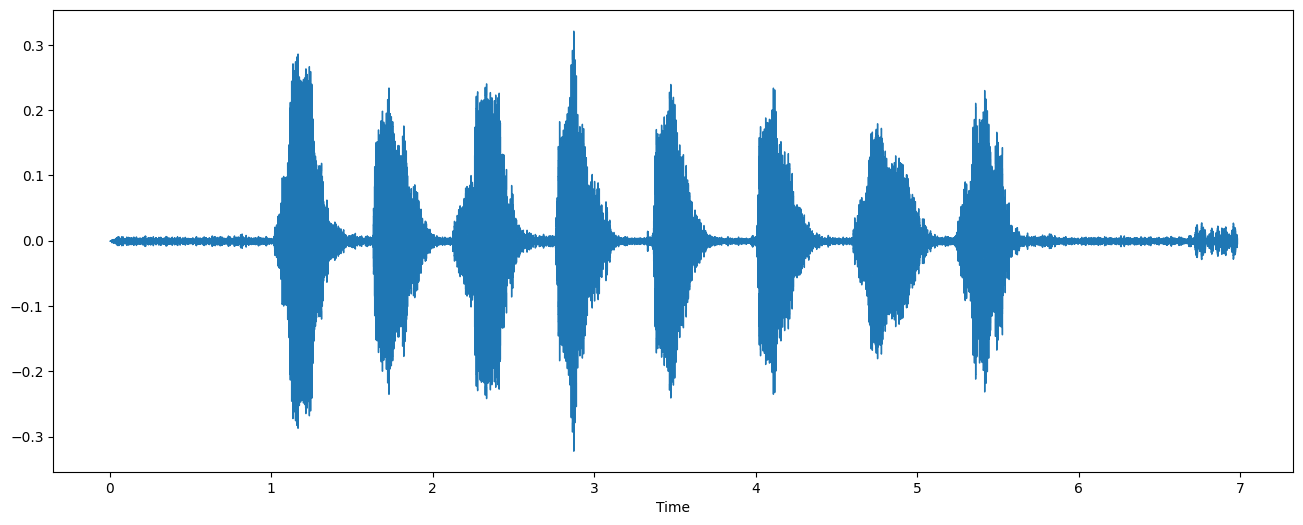

In [4]:
plt.figure(figsize=(16, 6))
librosa.display.waveshow(y, sr=sr)
plt.show()

## Task 2

Для классификации обычно использует не просто аудио сигнал, а его частотно-временное представление. Для этого сигнал требуется
преобразовать с помощью [оконного преобразования Фурье](https://clck.ru/34JnZD).
С помощью функции [librosa.display.specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html) 
выведи спектрограмму сигнала. \
График должен быть такой же, как показано ниже (по значениям):
![sftp](../misc/images/sftp.png)

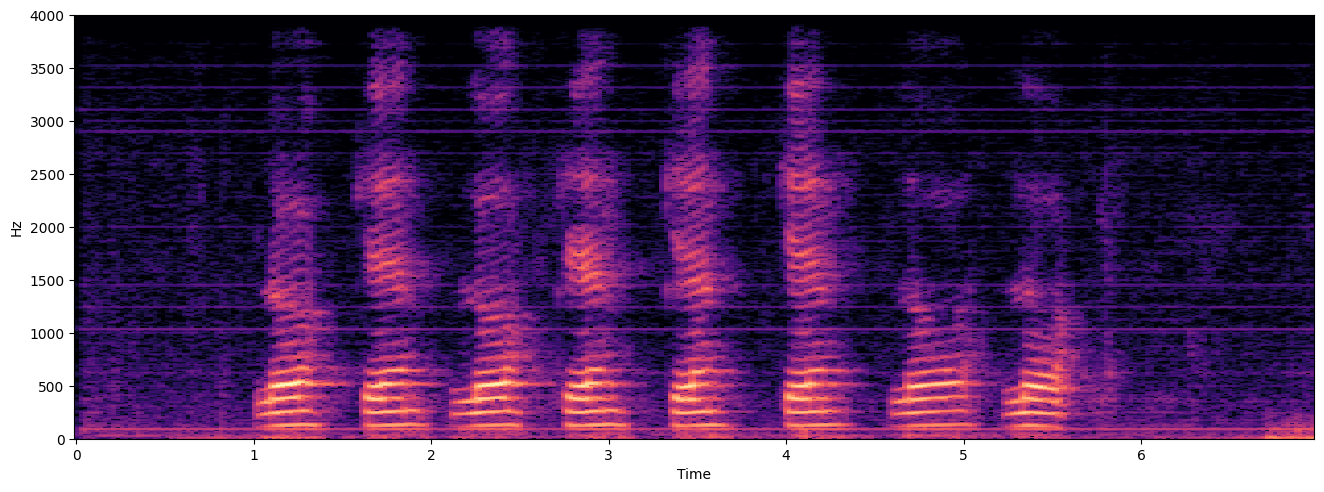

In [5]:
# Код тут
X = librosa.stft(y) ## преобразует данные в кратковременное преобразование Фурье.
Xdb = librosa.amplitude_to_db(abs(X)) ## преобразует амплитудные сигналы в децибелы
plt.figure(figsize=(16, 5.5
                   ))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.ylim([0,4000])
# plt.colorbar()
plt.show()


## Task 3

C помощью функции [load_dataset](code-samples/audio_utils.py) загрузи датасет. \
Раздели его на train и test c параметрами `test_size=0.2`, `random_state=42`. \
Выведи количество файлов в train и test частях.

In [6]:
from glob import glob # расширение файлов
import os # операционная система
from sklearn.model_selection import train_test_split # разделение выборки на тест и трейн

In [7]:
def load_dataset(directory: str):
    sr = None
    X, labels, files = [], [], [] # создаем пустые списки
    for f in glob(directory + "/*.wav"): #цикл по файлам с расширение вав в указанной папке
        filename = os.path.basename(f) # находим базовое имя файла
        name = filename[:-4] # имя файла без расширения (убираем последние 4 знака)
        y = [int(label) for label in name.split("_")] # получаем метки из названия (0 и 1)
        x, sr = librosa.load(f) 
        X.append(x) # добавляем аудифайл в список
        labels.append(y) # добавляем метки в список
        files.append(filename) # добавляем название файла вместе с расширением

    return X, labels, sr, files

In [8]:
# Код тут
directory = '../datasets/waves_yesno 2' # вызываем функцию
X, labels, sr, files = load_dataset(directory)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
print('Количество файлов в train части', len(X_train))
print('Количество файлов в test части', len(X_test))

Количество файлов в train части 47
Количество файлов в test части 12


## Task 4

Наши аудио записи содержат как речь человека, так и молчание. Для каждой записи нам нужно определить сегменты записи, 
где человек молчит, а где произносит слова. \
Эта задача называется [Voice Activity Detection (VAD)](https://ru.wikipedia.org/wiki/Voice_Activity_Detection).
Придумайте или найдите метод, по которому можно распознавать участки с речью на аудио записи.

Например:
Запись '0_0_0_1_0_1_1_0.wav' содержит 137592 отсчетов. Сегменты с речью для этой записи (Отмечены красным):
[[23996, 32539],
 [35410, 44925],
 [49493, 57410],
 [60458, 68635],
 [73308, 81278],
 [84001, 91942],
 [97381, 104166],
 [109018, 115573]] 
![sftp](../misc/images/vad.png)

Выведи несколько примеров работы твоего VAD-алгоритма, по аналогии с примером, для других аудио записей. Попробуй добиться
наилучшего качества нахождения речи.

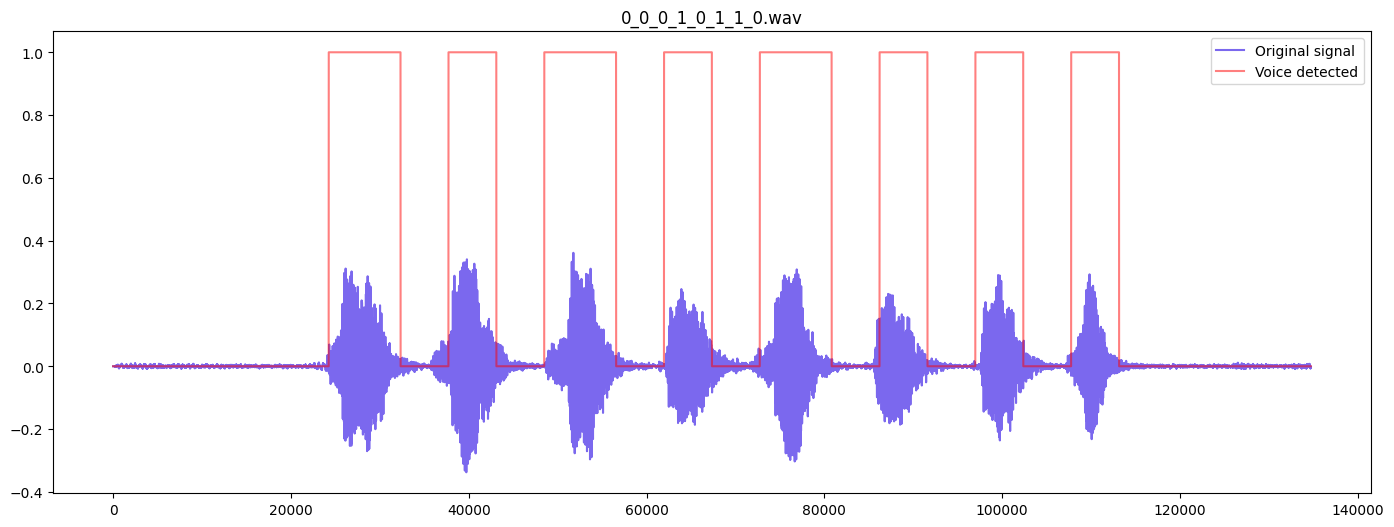

Запись 0_0_0_1_0_1_1_0.wav содержит 134726 отсчетов

Участки с речью:
(24246, 32328)
(37716, 43104)
(48492, 56574)
(61962, 67350)
(72738, 80820)
(86208, 91596)
(96984, 102372)
(107760, 113148)


In [9]:
# Код тут
# функция VAD по пороговому значению сигнала
def vad(audio, window_size=0.02, threshold=0.03):
    # определение размера окна в отсчетах
    window_length = int(window_size * len(audio))

    # разделение аудио на окна
    windows = [audio[i:i+window_length] for i in range(0, len(audio)-window_length+1, window_length)]

    # расчет энергии для каждого окна
    energies = [np.sum(np.square(window)) for window in windows]

    # установка порогового значения энергии
    threshold_value = threshold * np.max(energies)

    # определение участков с речью
    speech_segments = []
    in_speech = False
    start = 0

    for i, energy in enumerate(energies):
        if not in_speech and energy > threshold_value:
            in_speech = True
            start = i
        elif in_speech and energy < threshold_value:
            in_speech = False
            end = i
            speech_segments.append((start * window_length, end * window_length))

    # Возврат участков с речью
    return speech_segments

# функция построения графика
def plot_vad_segments(audio):
    # Расчет времени для каждого отсчета
    duration = len(audio) / sr
    times = np.linspace(0., duration, len(audio)) 
    # построение графика аудио
    plt.figure(figsize=(17, 6))
    plt.plot(audio, color='mediumslateblue', label='Original signal')
    
   

    # выделение участков с речью красным цветом
    # for segment in segments:
    #     start, end = segment
    #     plt.axvspan(start / sr, end / sr, color='red', alpha=0.5, label='Voice detected')
    speech_line = np.zeros(len(audio))
    for segment in segments:
        speech_line[segment[0]:segment[1]] = 1
    plt.plot(speech_line, color='red', alpha=0.5, label='Voice detected')

    # настройки графика
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')
    plt.title(os.path.basename(audio_file))
    # plt.grid(True)
   

    # отображение графика
    plt.legend()
    plt.show()
    
# загрузка аудио файла и применение VAD
audio_file = '../datasets/waves_yesno 2/0_0_0_1_0_1_1_0.wav'
audio, sr = librosa.load(audio_file)

# применение VAD
segments = vad(audio)






# построение графика с выделением участков с речью
plot_vad_segments(audio)

# вывод найденных участков с речью
f = os.path.basename(audio_file)
print('Запись', f, 'содержит', len(audio), 'отсчетов')
print()
print("Участки с речью:")
for segment in segments:
    print(segment)


## Task 5

После того как мы узнали сегменты аудио с речью, то можно перейти к самой задаче классификации. \
Внимательно изучи функцию [make_dataset](code-samples/audio_utils.py). С помощью этой функции cгенерируй X, Y для train и test выборок.
Затем попробуй обучить различные классификаторы. Например, SVM или LogisticRegression.
Измерь точность (accuracy) классификации на тестовой выборке.

In [10]:
def make_dataset(samples, labels, vad_segments):
    """

    :param samples: Список аудио сигналов
    :param labels: Список меток (Например для файла '0_0_0_1_0_1_1_0.wav': [0, 0, 0, 1, 0, 1, 1, 0])
    :param vad_segments: Список сегментов для каждого аудио сигнала вида:
        [
            [[23996, 32539], [35410, 44925], ...,],
            [[22141, 30259], [34917, 42695], ...,],
            ...
        ]
    :return:
    """
    X, y = [], []
    # Проходим по каждому аудио сигналу
    for sample in range(len(samples)):
        # В аудио сигнале проходим по каждому сегменту с речью
        for segment in range(len(vad_segments[sample]) - 1):
            start = vad_segments[sample][segment][0]  # Начало сегмента
            stop = vad_segments[sample][segment][1]  # Конец сегмента
            voice = samples[sample][start:stop]  # Отрезаем сегмент с речью из аудио сигнала и применяем stft
            stft = librosa.stft(voice).mean(axis=1)
            stft_db = librosa.amplitude_to_db(abs(stft))

            X.append(stft_db)  # Добавляем спектрограмму с речью
            y.append(labels[sample][segment])  # Добавляем метку для этой спектрограммы

    return np.array(X), np.array(y)

In [11]:
audio_folder = '../datasets/waves_yesno 2/'

samples = []
labels = []
vad_segments = []

# обработка каждого аудиофайла
for file_name in os.listdir(audio_folder):
    if file_name.endswith('.wav'):
        file_path = os.path.join(audio_folder, file_name)

        # загрузка аудиофайла и применение VAD
        audio, sr = librosa.load(file_path)
        segments = vad(audio)

        # добавление аудио и меток в соответствующие списки
        label_digits = file_name.split('.')[0].split('_')[:8]
        label = [int(digit) for digit in label_digits]
        labels.append(label)
        samples.append(audio)
        vad_segments.append(segments)

In [12]:
# генерация X и Y
X, y = make_dataset(samples, labels, vad_segments)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Код тут
# SVM
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# обучение модели SVM
svm = SVC()
svm.fit(X_train, y_train)

# предсказание меток классов для тестовых данных
y_pred = svm.predict(X_test)

# измерение точности классификации
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9634146341463414


In [15]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# создание экземпляра модели Logistic Regression
model = LogisticRegression(max_iter=500)

# обучение модели на тренировочных данных
model.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred = model.predict(X_test)

# оценка точности модели
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9634146341463414
